##Problem statement

Company X aims to optimize the delivery of fast-moving consumer goods (FMCGs) to informal retailers by implementing a dynamic routing strategy that minimizes costs and maximizes vehicle utilization. The current challenge lies in determining the most efficient delivery routes that reduce travel distances while ensuring vehicles are fully utilized.

To address this, the case study focuses on clustering shops (identified by customer_id) around fulfillment centers. By grouping shops efficiently, Company X can improve delivery route optimization, reducing travel distances and enhancing vehicle utilization. The objective is to create cluster assignments and visualize them on a map, forming the basis for dynamic routing.

This clustering solution will enable Company X to meet demand efficiently within each delivery window and territory, ensuring that the overall delivery process is both cost-effective and logistically streamlined.

# Implementation Steps
1. Load the required libraries and datasets.
2. Preprocess the data by checking for missing values and cleaning the dataset.
3. Determine the optimal number of clusters using the length of the centroids in the
warehouse centroids dataset
4. Fit the K-Means clustering model to the shop locations (latitude and longitude).
5. Assign clusters to shops based on the model predictions.
6. Generate a CSV output file containing shop IDs and their corresponding cluster
assignments.
7. Visualize the clusters on a map, showing shop locations and centroids.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [25]:
df = pd.read_csv('/content/drive/MyDrive/phoenix_analytics/Copy of dataset.csv')
centroids_df= pd.read_csv('/content/drive/MyDrive/phoenix_analytics/Copy of territories_centroids.csv')
centroids_df.head()

,id,territory,warehouse_latitude,warehouse_longitude
0,1,Athi River,-1.427556,36.970444
1,2,Eastlands,-1.324139,36.867000
2,3,Eldoret,0.520185,35.256327
3,4,Embu,-0.542030,37.454250
4,5,Juja,-1.108111,37.013861


In [26]:
#Understanding the dataset
df.head(1)

,order_id,customer_number,transaction_date,description,total_qty,net_total,loyalty_amount,loyalty_points,discount_amount,customer_group,territory,delivery_date,delivery_window_end_time,delivery_window_start_time,set_warehouse,duka_latitude,duka_longitude
0,04aeddd4-d9b3-4cca-ab3b-072ca177a3e1,ID_172101,28/03/2022,Steam Energy Energy Drink 400ML CARTON (1.0 Item),6,2231.57,0,0,66.38,Individual,Meru,29/03/2022,19:00:00,13:00:00,Meru Main - KDKE,0.036784,37.654155


In [27]:
# df description
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43718 entries, 0 to 43717
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   order_id                    43718 non-null  object 
 1   customer_number             43718 non-null  object 
 2   transaction_date            43718 non-null  object 
 3   description                 43718 non-null  object 
 4   total_qty                   43718 non-null  int64  
 5   net_total                   43718 non-null  float64
 6   loyalty_amount              43718 non-null  int64  
 7   loyalty_points              43718 non-null  int64  
 8   discount_amount             43718 non-null  float64
 9   customer_group              43718 non-null  object 
 10  territory                   43718 non-null  object 
 11  delivery_date               43718 non-null  object 
 12  delivery_window_end_time    43718 non-null  object 
 13  delivery_window_start_time  437

In [28]:
#check for duplicates
print("Number of Duplicated observations:", df.duplicated().sum(),"\n")
print ("Dataframe of Duplicated Observations \n")
df[df.duplicated()]

Number of Duplicated observations: 10 

Dataframe of Duplicated Observations 



,order_id,customer_number,transaction_date,description,total_qty,net_total,loyalty_amount,loyalty_points,discount_amount,customer_group,territory,delivery_date,delivery_window_end_time,delivery_window_start_time,set_warehouse,duka_latitude,duka_longitude
8667,8f0a8d99-e06c-4619-a4dc-539b323e15d3,ID_113558,03/03/2022,Sunveat Biscuits Wafers 15G Assorted CARTON (1...,10,5120.68,0,0,60.0,Individual,Juja,04/03/2022,14:00:00,08:00:00,Juja Main - KDKE,-1.055031,36.949011
10045,417a6bbf-026a-422f-b588-0d8e380267d1,ID_145802,25/02/2022,Local White Sugar 50KG BAG (1.0 Item),2,9661.04,0,0,113.2,Individual,Athi River,26/02/2022,14:00:00,08:00:00,Athi River Main - KDKE,-1.480278,36.965903
13036,4f16eb5c-396e-4570-9111-2e82b28f38d4,ID_105214,07/03/2022,Steam Energy Energy Drink 400ML CARTON (1.0 Item),8,3980.48,0,0,43.6,Individual,Nakuru,07/03/2022,19:00:00,13:00:00,Nakuru Main - KDKE,-0.286954,36.074642
13038,4f16eb5c-396e-4570-9111-2e82b28f38d4,ID_105214,07/03/2022,Softcare Sanitary Pads PURPLE 12PC CARTON (2.0...,8,3980.48,0,0,43.6,Individual,Nakuru,07/03/2022,19:00:00,13:00:00,Nakuru Main - KDKE,-0.286954,36.074642
23133,63620ae5-c9ad-413e-a9b9-126ba8feeb91,ID_047131,15/02/2022,Mt. Kenya Milk ESL 500ML CARTON (1.0 Item),38,24321.22,0,0,263.6,Individual,Meru,16/02/2022,19:00:00,13:00:00,Meru Main - KDKE,0.132581,37.539296
23135,63620ae5-c9ad-413e-a9b9-126ba8feeb91,ID_047131,15/02/2022,Mt. Kenya Milk ESL 200ML CARTON (1.0 Item),38,24321.22,0,0,263.6,Individual,Meru,16/02/2022,19:00:00,13:00:00,Meru Main - KDKE,0.132581,37.539296
23137,63620ae5-c9ad-413e-a9b9-126ba8feeb91,ID_047131,15/02/2022,Zenta Bar Soap Cream 1Kg CARTON (10.0 PC),38,24321.22,0,0,263.6,Individual,Meru,16/02/2022,19:00:00,13:00:00,Meru Main - KDKE,0.132581,37.539296
26735,8cb0c10a-b778-4a80-8a4c-87406bfc0cdf,ID_174183,02/03/2022,Ajab Wheat Flour 2KG BALE (12.0 PC),4,6286.50,0,0,63.5,Individual,Athi River,03/03/2022,14:00:00,08:00:00,Athi River Main - KDKE,-1.349662,36.977445
26737,8cb0c10a-b778-4a80-8a4c-87406bfc0cdf,ID_174183,02/03/2022,Pembe Maize Flour 2KG BALE (12.0 PC),4,6286.50,0,0,63.5,Individual,Athi River,03/03/2022,14:00:00,08:00:00,Athi River Main - KDKE,-1.349662,36.977445
30603,790e2efd-e39b-407e-a8bb-97bb708dbb92,ID_041606,24/02/2022,Local White Sugar 50KG BAG (1.0 Item),4,19322.06,0,0,226.4,Individual,Ruiru,25/02/2022,14:00:00,08:00:00,Ruiru Main - KDKE,-1.129606,36.968379


In [29]:
#Drop duplicates
df = df.drop_duplicates(keep ='first')

In [30]:
#Review duplicated
df.duplicated().sum()

0

In [31]:
#select columns that will be used
df =df[['customer_number','territory','total_qty','net_total','discount_amount','duka_latitude','duka_longitude' ]]
df.head()

,customer_number,territory,total_qty,net_total,discount_amount,duka_latitude,duka_longitude
0,ID_172101,Meru,6,2231.57,66.38,0.036784,37.654155
1,ID_172101,Meru,6,2231.57,66.38,0.036784,37.654155
2,ID_172101,Meru,6,2231.57,66.38,0.036784,37.654155
3,ID_172101,Meru,5,3637.91,38.53,0.036784,37.654155
4,ID_172101,Meru,5,3637.91,38.53,0.036784,37.654155


In [32]:
#drop irrelevant columns in territories df
centroids_df.drop(columns = 'id', inplace = True)

In [33]:
#Check for duplicates
print("Number of Duplicated observations:", centroids_df.duplicated().sum())

Number of Duplicated observations: 0


In [34]:
merged_df = df.merge(centroids_df, how = "inner", on = ["territory"])
merged_df.head(2)

,customer_number,territory,total_qty,net_total,discount_amount,duka_latitude,duka_longitude,warehouse_latitude,warehouse_longitude
0,ID_172101,Meru,6,2231.57,66.38,0.036784,37.654155,-1.277078,36.814669
1,ID_172101,Meru,6,2231.57,66.38,0.036784,37.654155,-1.277078,36.814669


In [35]:
#check for duplicates
print("Number of Duplicated observations:", merged_df.duplicated().sum())

Number of Duplicated observations: 23897


In [36]:
#Drop the duplicates
merged_df = merged_df.drop_duplicates(keep ='first')

In [37]:
#review duplicates
print(merged_df.duplicated().sum())

0


In [38]:
#check shape of new df
merged_df.shape

(19811, 9)

In [39]:
centroids_df.head(2)

,territory,warehouse_latitude,warehouse_longitude
0,Athi River,-1.427556,36.970444
1,Eastlands,-1.324139,36.867000


In [40]:
unique_territories = merged_df['territory'].unique()
unique_territories

array(['Meru', 'Athi River', 'Nakuru', 'Thika Rd', 'Mtwapa Mombasa',
       'Eastlands', 'Kawangware', 'Majengo Mombasa', 'Ruiru', 'Ruai',
       'Voi', 'Kiambu', 'Eldoret', 'Embu', 'Juja', 'Ongata Rongai',
       'Kisumu1', 'Kisii', 'Karatina'], dtype=object)

# Geospatial Clustering

1. Perform K-means clustering

In [41]:
# Extracting and renaming columns for shops
shops = merged_df[['duka_latitude', 'duka_longitude']].copy()
shops.head(2)

,duka_latitude,duka_longitude
0,0.036784,37.654155
3,0.036784,37.654155


In [42]:
# Perform K- means clustering
X =shops [ [ 'duka_latitude' , 'duka_longitude' ]]
k = len( centroids_df)
kmeans = KMeans ( n_clusters =k , random_state =42 , n_init =10)
shops ['cluster_no'] = kmeans.fit_predict (X)

In [43]:
# Create a mapping of cluster numbers to warehouse coordinates
cluster_to_warehouse = {}

# Iterate over each centroid (cluster center) obtained from K-means clustering
for i, centroid in enumerate(kmeans.cluster_centers_):
    # Calculate the Euclidean distance from the current centroid to all warehouse coordinates
    distances = np.sqrt(
        ((centroids_df[['warehouse_latitude', 'warehouse_longitude']].values - centroid) ** 2).sum(axis=1)
    )

    # Find the index of the closest warehouse by identifying the minimum distance
    closest_warehouse = centroids_df.iloc[distances.argmin()]

    # Store the closest warehouse's latitude, longitude, and territory in the dictionary
    cluster_to_warehouse[i] = {
        'warehouse_latitude': closest_warehouse['warehouse_latitude'],  # Latitude of the closest warehouse
        'warehouse_longitude': closest_warehouse['warehouse_longitude'],  # Longitude of the closest warehouse
        'territory': closest_warehouse['territory']  # Territory of the closest warehouse
    }

# Add warehouse coordinates and territory to the shops DataFrame
# Map the warehouse latitude to each shop based on its cluster number
shops['warehouse_latitude'] = shops['cluster_no'].map(
    lambda x: cluster_to_warehouse[x]['warehouse_latitude']
)

# Map the warehouse longitude to each shop based on its cluster number
shops['warehouse_longitude'] = shops['cluster_no'].map(
    lambda x: cluster_to_warehouse[x]['warehouse_longitude']
)

# Map the assigned territory to each shop based on its cluster number
shops['assigned_territory'] = shops['cluster_no'].map(
    lambda x: cluster_to_warehouse[x]['territory']
)


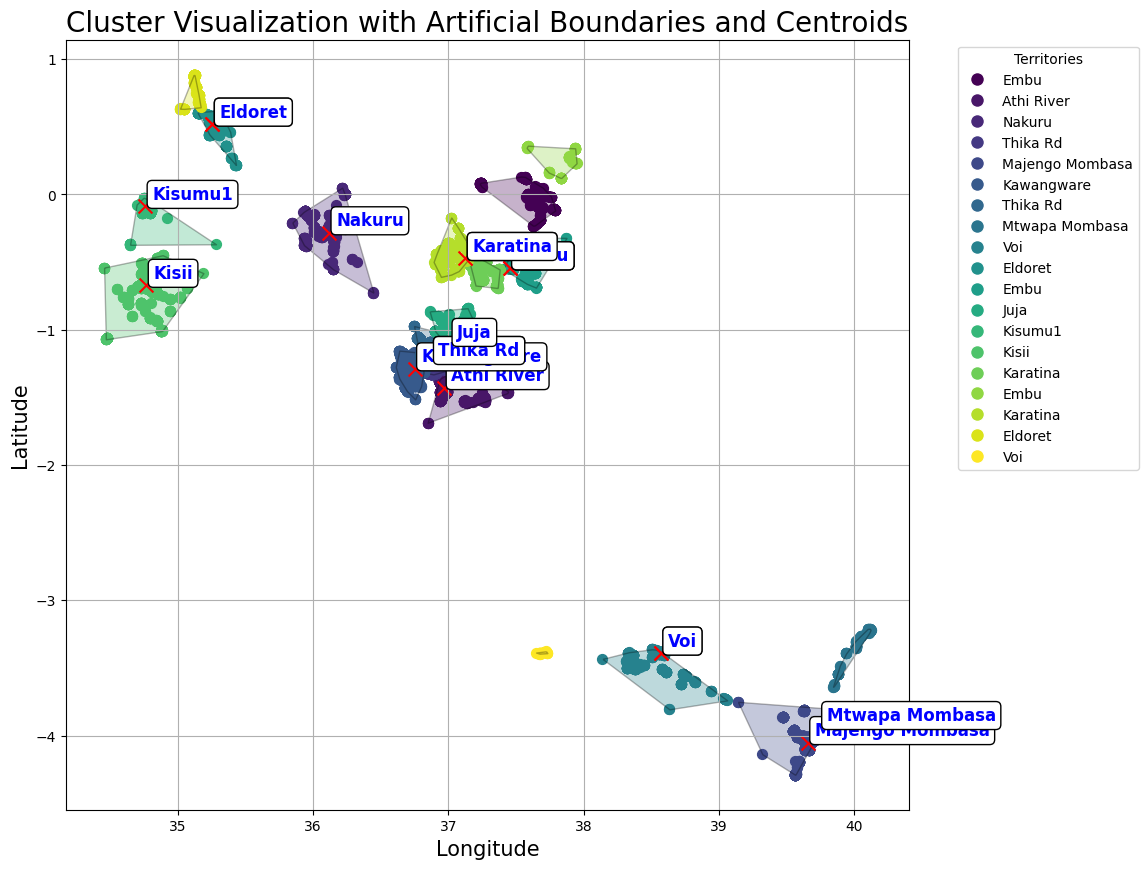

Cluster map saved as clusters_map.png


In [45]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np

def plot_cluster(ax, cluster_data, color, cluster):
    """
    Plots a cluster on the given axes with the cluster data, convex hull,
    centroid, and territory annotations.
    """
    # Plot the cluster points
    cluster_data.plot(ax=ax, marker='o', color=color, markersize=50)

    # Plot the convex hull if the cluster has more than 2 points
    if len(cluster_data) > 2:
        points = cluster_data[['duka_longitude', 'duka_latitude']].values
        hull = ConvexHull(points)
        hull_polygon = Polygon(points[hull.vertices])
        gpd.GeoSeries([hull_polygon]).plot(ax=ax, facecolor=color, edgecolor='k', alpha=0.3)

    # Plot the centroid
    centroid = cluster_data[['warehouse_longitude', 'warehouse_latitude']].iloc[0]
    gpd.GeoSeries([Point(centroid)]).plot(ax=ax, marker='x', color='red', markersize=100)

    # Annotate the territory name
    territory_name = cluster_data['assigned_territory'].iloc[0]
    plt.annotate(
        territory_name,
        tuple(centroid),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=12,
        fontweight='bold',
        color='blue',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
    )

    return territory_name

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(shops['duka_longitude'], shops['duka_latitude'])]
gdf = gpd.GeoDataFrame(shops, geometry=geometry, crs="EPSG:4326")

# Plot setup
fig, ax = plt.subplots(figsize=(15, 10))
colors = plt.cm.viridis(np.linspace(0, 1, len(gdf['cluster_no'].unique())))

# Plot clusters and create legend handles
handles = []
for cluster, color in zip(gdf['cluster_no'].unique(), colors):
    cluster_data = gdf[gdf['cluster_no'] == cluster]
    territory_name = plot_cluster(ax, cluster_data, color, cluster)
    handles.append(
        plt.Line2D(
            [0], [0], marker='o', color='w', markerfacecolor=color,
            markersize=10, label=territory_name
        )
    )

# Finishing touches
plt.title('Cluster Visualization with Artificial Boundaries and Centroids', fontsize=20)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.legend(handles=handles, title="Territories", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Save and show plot
#plt.savefig('results/clusters_map.png', dpi=300, bbox_inches='tight')
plt.show()

print("Cluster map saved as clusters_map.png")


In [47]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 50.0 MB/s eta 0:00:00


<ipython-input-48-1a7f324f9fa3>:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(gdf['cluster_no'].unique()))


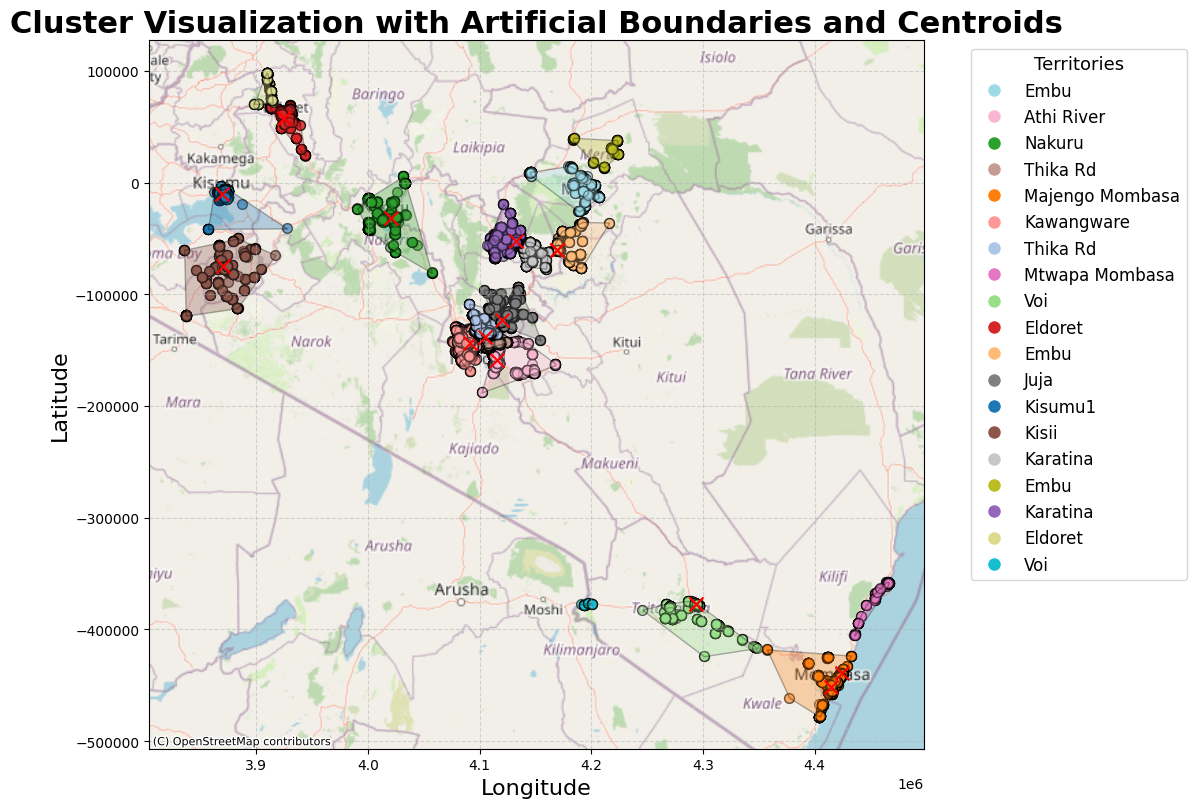

Cluster map saved as results/clusters_map2.png


In [48]:
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

def plot_cluster(ax, cluster_data, color):
    """
    Plots a cluster with convex hull, centroid, and territory annotation.
    """
    # Plot the cluster points
    cluster_data.plot(
        ax=ax, marker='o', color=color, markersize=50, alpha=0.6, edgecolor='k'
    )

    # Plot the convex hull if there are enough points
    if len(cluster_data) > 2:
        hull_points = cluster_data[['duka_longitude', 'duka_latitude']].values[
            ConvexHull(cluster_data[['duka_longitude', 'duka_latitude']].values).vertices
        ]
        gpd.GeoSeries([Polygon(hull_points)], crs="EPSG:4326") \
           .to_crs(epsg=3857) \
           .plot(ax=ax, facecolor=color, edgecolor='k', alpha=0.3)

    # Plot the centroid
    centroid = cluster_data[['warehouse_longitude', 'warehouse_latitude']].iloc[0]
    centroid_point = Point(centroid)
    gpd.GeoSeries([centroid_point], crs="EPSG:4326") \
       .to_crs(epsg=3857) \
       .plot(ax=ax, marker='x', color='red', markersize=100)

    # Annotate the territory name
    territory_name = cluster_data['assigned_territory'].iloc[0]
    plt.annotate(
        territory_name,
        (centroid_point.x, centroid_point.y),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=12,
        fontweight='bold',
        color='blue',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
    )

    return territory_name

# Create GeoDataFrame and convert to Web Mercator
gdf = gpd.GeoDataFrame(
    shops,
    geometry=[Point(xy) for xy in zip(shops['duka_longitude'], shops['duka_latitude'])],
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Plot setup
fig, ax = plt.subplots(figsize=(10, 10))
colors = plt.cm.get_cmap('tab20', len(gdf['cluster_no'].unique()))

# Plot clusters and create legend handles
handles = []
for cluster in gdf['cluster_no'].unique():
    color = colors(cluster)
    territory_name = plot_cluster(ax, gdf[gdf['cluster_no'] == cluster], color)
    handles.append(
        plt.Line2D(
            [0], [0], marker='o', color='w', markerfacecolor=color,
            markersize=10, label=territory_name
        )
    )

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Finishing touches
plt.title('Cluster Visualization with Artificial Boundaries and Centroids', fontsize=22, fontweight='bold')
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.legend(handles=handles, title="Territories", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize='13')
plt.grid(True, linestyle='--', alpha=0.5)

# Ensure output directory exists
import os
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Save and show plot
output_file = os.path.join(output_dir, 'clusters_map2.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"Cluster map saved as {output_file}")


**Territory Clusters:** The map shows multiple clusters, each representing aa specific territory, such as Nakuru, Mptwapa etc. Each cluster is colored fifferently to distinguish between the territories.

**Geographical Distribution:** The clusters are spread across different regions of Kenya and their locations are plotted based on latitude and longitude. The map helps in understanding how the territories are distributed across the country.

**Centroid:** The centroids (marked by X) represent the central point of each cluster, which might be used as a reference for further analysis such as dynamic routing or resource allocation.

**Territory Labels:** The legend on the right side of the image associates each color with a specific territory name, helping to easily identify and differentiate between clusters on the map.